## Bank Marketing Campaign Analysis


 ## 1. Feature Description

**Bank client data:**

>1 - age (numeric)<br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - education (categorical: basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')<br>
5 - default: has credit in default? (categorical: 'no','yes','unknown')<br>
6 - housing: has housing loan? (categorical: 'no','yes','unknown')<br>
7 - loan: has personal loan? (categorical: 'no','yes','unknown')<br>

**Related with the last contact of the current campaign:**

>8 - contact: contact communication type (categorical: 'cellular','telephone')<br>
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). <br>
Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
other attributes:

**Campaign Attributes:**
>12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
social and economic context attributes<br>

**Socio-Economic Attributes:**
>16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)<br>
17 - cons.price.idx: consumer price index - monthly indicator (numeric)<br>
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)<br>
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)<br>
20 - nr.employed: number of employees - quarterly indicator (numeric)<br>

**Ouput Target Variable**
>21 - y - has the client subscribed a term deposit? (binary: 'yes','no')<br>

In [45]:
# Import relevant packages
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn import linear_model as lm
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn import neighbors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')
pd.set_option('display.max_columns', 500)

In [84]:
# Import full data
df = pd.read_csv('BankCampaign/BankMarketingCampaign/Datasets/bank-additional-full.csv', sep = ';')
df['y'] = df['y'].map({'yes': 1, 'no': 0})

### Bucket columns by preditor type

In [68]:
bank_client_data = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
campaign_data = ['contact', 'month', 'day_of_week', 'duration']
social_eco_data = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
other_data = ['campaign', 'previous', 'poutcome', 'pdays']

In [70]:
def describe_new(df):
    #describe for all types of columns inluding top and no_missing
    out = df.describe(include='all')
    for c in df.columns.tolist(): 
        out.loc['type', c] = df.dtypes.to_dict()[c]
        out.loc['missing', c] = sum(df[c].isnull().values)
    out = out.T.sort_values('type').T
    return out.fillna('-')

def exploratory_plot(f):
    #a1 is current axis, dTypes is global dictionary
    #if the variable is string-type plot a countplot with a pointplot of mean_y as an overlay
    #if the variable is numeric plot a boxplot for each level of Y
    if df.dtypes[f]=='object':
        a2 = a1.twinx()
        sns.countplot(f, data=df, ax=a1)
        sns.pointplot(f, 'y', data=df, ci=95, linestyles='', color='black', scale=1.5, ax=a2)
        a1.set(xlabel='', ylabel='')
        a2.set(ylabel='', ylim=(0, 1))
        a1.set_xticklabels(a1.xaxis.get_majorticklabels(), rotation=45)
        a1.set_title(f, size=20)
    else:
        sns.boxplot(f, 'y', data=df, orient='h', ax=a1)
        a1.set_title(f, fontsize=20)
        a1.set(xlabel='', ylabel='Y')

    
def get_dummies(df, col):
    #get dummies, drop first, join back to dataframe, drop original column
    dummies = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)
    df.drop(col, axis=1, inplace=True)
    return df.join(dummies)


def single_predictor_auc(col):
    #for each column, run logistic regression with only that feature, return area under curve of the model and avg prec recall
    m = lm.LogisticRegression()
    if str(df[col].dtype)!='object': 
        X = df[[col]]
    else: 
        X = pd.get_dummies(df[col], drop_first=True)
    y = df.y
    m.fit(X, y)
    return roc_auc_score(y, m.predict_proba(X)[:,-1]), average_precision_score(y, m.predict_proba(X)[:,-1])


def run_LR(df, columns, name):
    #run LR on full data set, return coefficient matrix, auc, pr score, and roc and pr plots
    print([c for c in columns])
    df = df[columns+['y']]
    need_dummy = [c for c in df.columns if dTypes[c]=='object']
    for c in need_dummy:
        df = get_dummies(df, c)
    X, y = df[[c for c in df.columns if c!='y']], df.y
    lr_model = lm.LogisticRegression()
    lr_model.fit(X, y)
    prediction = lr_model.predict_proba(X)[:, -1]
    odds = [np.exp(i) for i in lr_model.coef_[0]]
    absv = [abs(i) for i in lr_model.coef_[0]]
    coef_matrix = pd.DataFrame(zip(X.columns.tolist(), list(lr_model.coef_[0]), odds, absv), columns=['feature', 'coef', 'odds', 'absv']).sort_values('absv', ascending=False).drop('absv', axis=1)
    print(coef_matrix)
    fpr, tpr, _ = roc_curve(y, prediction)
    prec, rec, _ = precision_recall_curve(y, prediction)
    auc = str(round(roc_auc_score(y, prediction), 2))
    avg_prec = str(round(average_precision_score(y, prediction), 2))
    fig, axs = plt.subplots(1, 2, figsize=(18, 3))
    fig.suptitle(name, y=1.1, fontsize=15)
    axs[0].plot(fpr, tpr, linewidth=2)
    axs[0].plot([0, 1], [0, 1], linestyle='--', color='k')
    axs[0].set_xlabel('fpr')
    axs[0].set_ylabel('tpr')
    axs[0].set_title('ROC Curve;   AUC: %s'%auc, fontsize=15)
    axs[1].plot(rec, prec, linewidth=2)
    axs[1].set_xlabel('rec')
    axs[1].set_ylabel('prec')
    axs[1].set_title('Precision Recall Curve;   Avg Prec: %s'%avg_prec, fontsize=15)
    plt.show()

In [64]:
describe_new(df)

,age,previous,pdays,campaign,duration,y,nr.employed,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,housing,loan,contact,month,day_of_week,education,marital,job,poutcome,default
count,41188.0,41188.0,41188.0,41188.0,41188.0,41188.0,41188.0,41188.0,41188.0,41188.0,41188.0,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,-,-,-,-,-,-,-,-,-,-,-,3,3,2,10,5,8,4,12,3,3
top,-,-,-,-,-,-,-,-,-,-,-,yes,no,cellular,may,thu,university.degree,married,admin.,nonexistent,no
freq,-,-,-,-,-,-,-,-,-,-,-,21576,33950,26144,13769,8623,12168,24928,10422,35563,32588
mean,40.02406,0.172963,962.475454,2.567593,258.28501,0.112654,5167.035911,0.081886,93.575664,-40.5026,3.621291,-,-,-,-,-,-,-,-,-,-
std,10.42125,0.494901,186.910907,2.770014,259.279249,0.316173,72.251528,1.57096,0.57884,4.628198,1.734447,-,-,-,-,-,-,-,-,-,-
min,17.0,0.0,0.0,1.0,0.0,0.0,4963.6,-3.4,92.201,-50.8,0.634,-,-,-,-,-,-,-,-,-,-
25%,32.0,0.0,999.0,1.0,102.0,0.0,5099.1,-1.8,93.075,-42.7,1.344,-,-,-,-,-,-,-,-,-,-
50%,38.0,0.0,999.0,2.0,180.0,0.0,5191.0,1.1,93.749,-41.8,4.857,-,-,-,-,-,-,-,-,-,-
75%,47.0,0.0,999.0,3.0,319.0,0.0,5228.1,1.4,93.994,-36.4,4.961,-,-,-,-,-,-,-,-,-,-


## Exploratory Analysis-
Categoricals: Bar Plot of Freq & Mean Y by Level <br>
Numeric: Boxplots for Y=0 and Y=1

In [72]:
keep = []

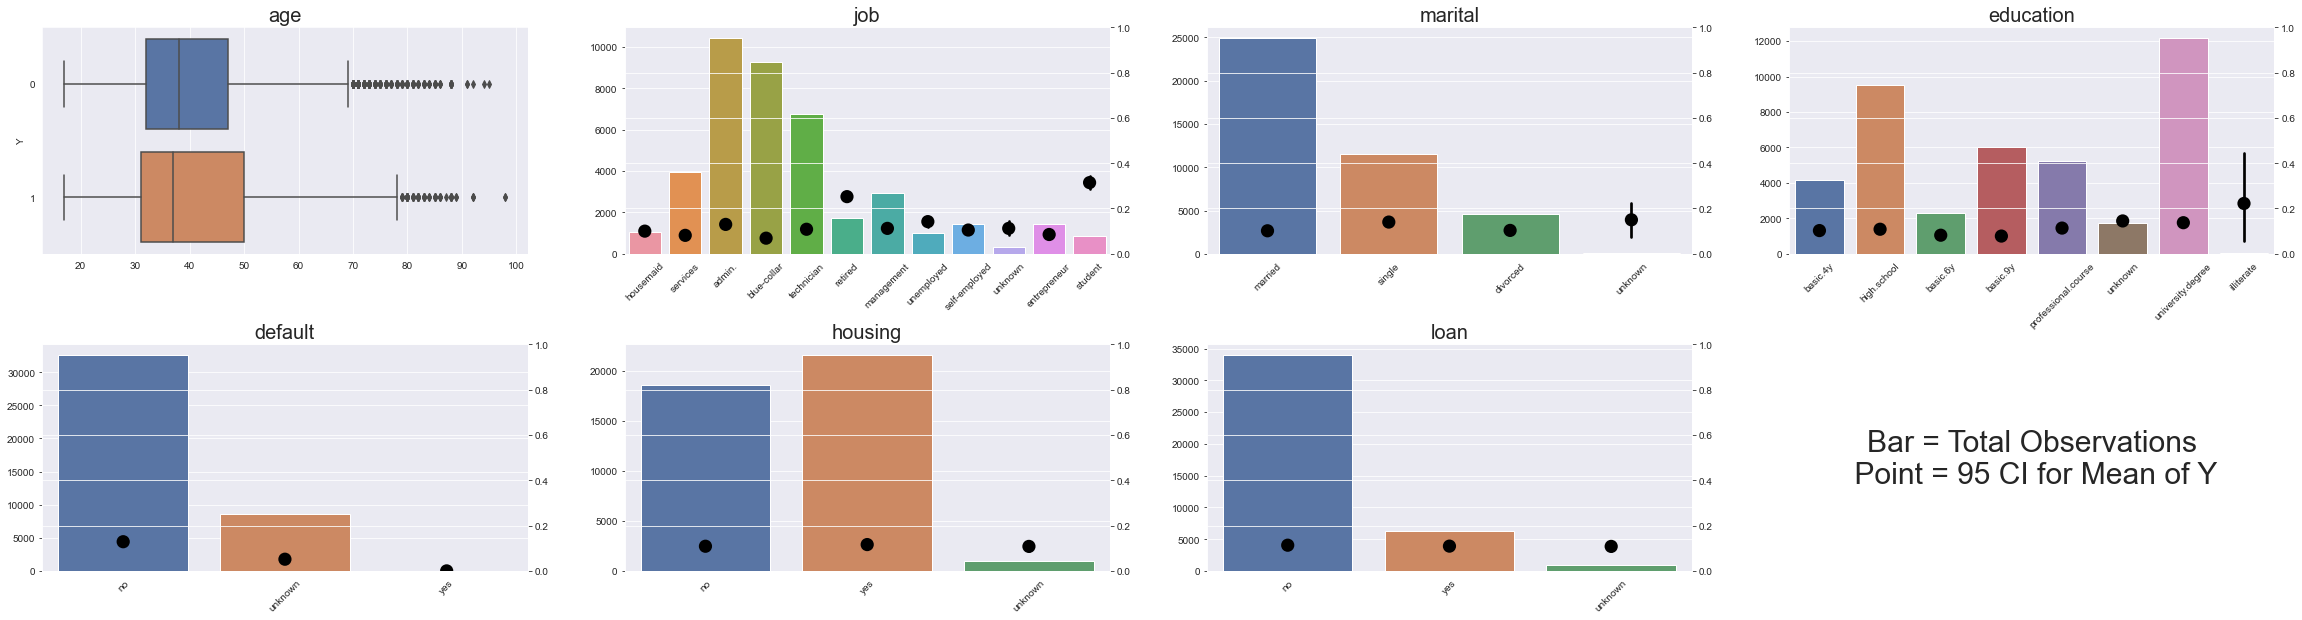

In [168]:
no_columns = 4
fig, axs = plt.subplots(2, no_columns, figsize=(40, 10))
        
for n, f in enumerate(bank_client_data):
    if n<no_columns: r, c = 0, n
    else: r, c = 1, n - no_columns
    a1 = axs[r,c]
    exploratory_plot(f)
    
fig.delaxes(axs[-1,-1]) 
axs[0,-1].set_xlabel('Bar = Total Observations\n Point = 95 CI for Mean of Y', size=30, labelpad=100)
plt.subplots_adjust(wspace=.2, hspace=.4)
plt.show()

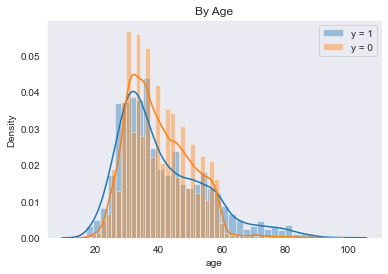

In [88]:
sns.distplot(df[df.y==1].age, label='y = 1')
sns.distplot(df[df.y==0].age, label='y = 0')
plt.legend()
plt.title('By Age');

In [91]:
df.job.unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

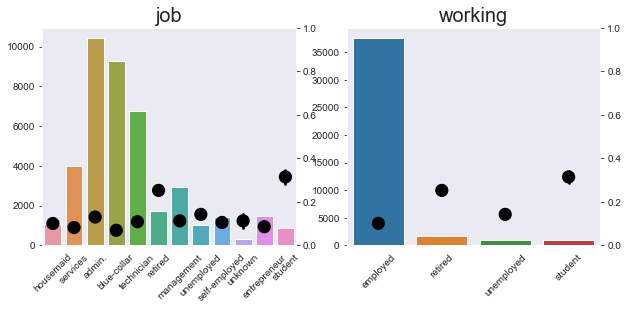

In [87]:
#consolidate job columns into working or not
f = lambda x: 'employed' if x not in ['unemployed', 'student', 'retired'] else x
df['working'] = df.job.apply(f)
dTypes = {k: str(v) for k, v in df.dtypes.to_dict().items()}

_, axs = plt.subplots(1, 2, figsize=(10, 4))
a1 = axs[0]
exploratory_plot('job')
a1 = axs[1]
exploratory_plot('working')

- Working may be a better predictor than Job, as mean y does not seem to depend on type of Job as much as working status

In [98]:
keep += ['working', 'age']

## Campaign Data

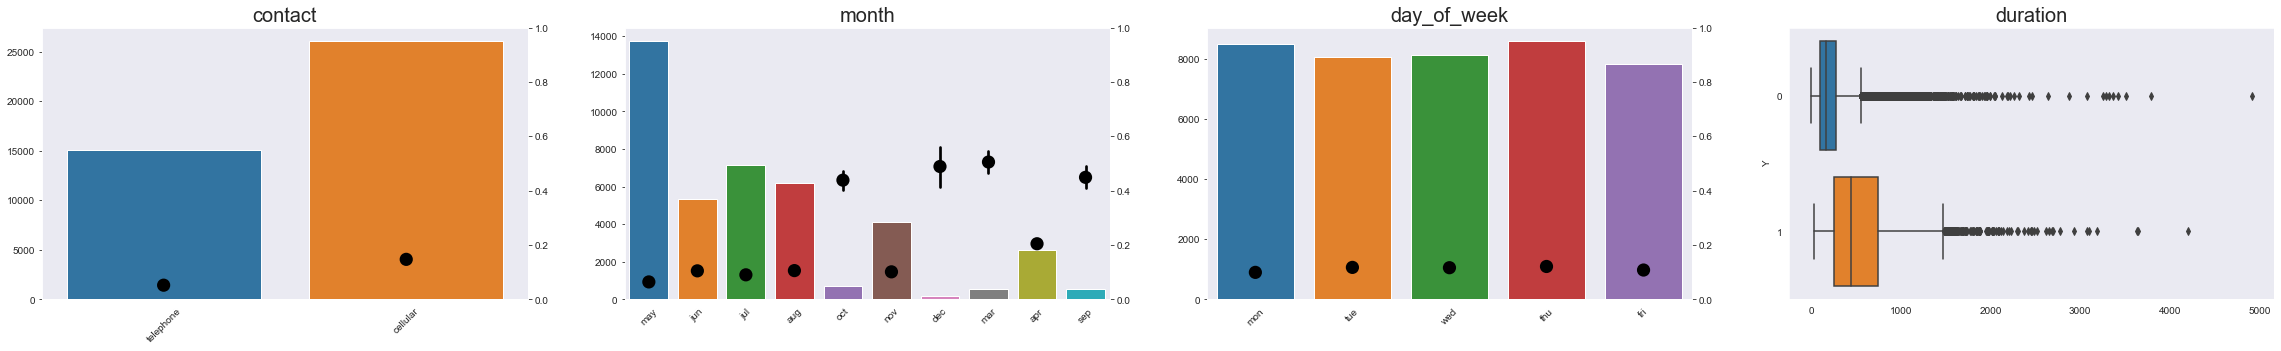

In [99]:
no_columns = 4
fig, axs = plt.subplots(1, no_columns, figsize=(40, 5))

for n, f in enumerate(campaign_data):
    a1 = axs[n]
    exploratory_plot(f)
        
plt.subplots_adjust(wspace=.2, hspace=.3)
plt.show()

- Month may be a good predictor

### Do cell phones lead to longer or shorter calls than home phones?

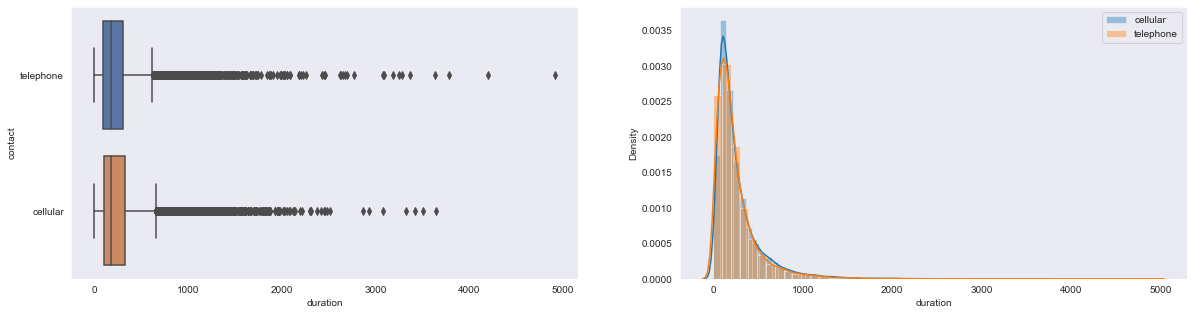

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.boxplot('duration', 'contact', data=df, orient='h', ax=axs[0], palette='deep')
sns.distplot(df[df.contact=='cellular'].duration, label='cellular', ax=axs[1])
sns.distplot(df[df.contact=='telephone'].duration, label='telephone', ax=axs[1])
axs[1].legend(loc='best');

- Contact may be a good predictor, as cell phones have a higher mean of y and this is not due to interaction with duration

In [102]:
keep += ['contact', 'month']

### Socio Eco Data

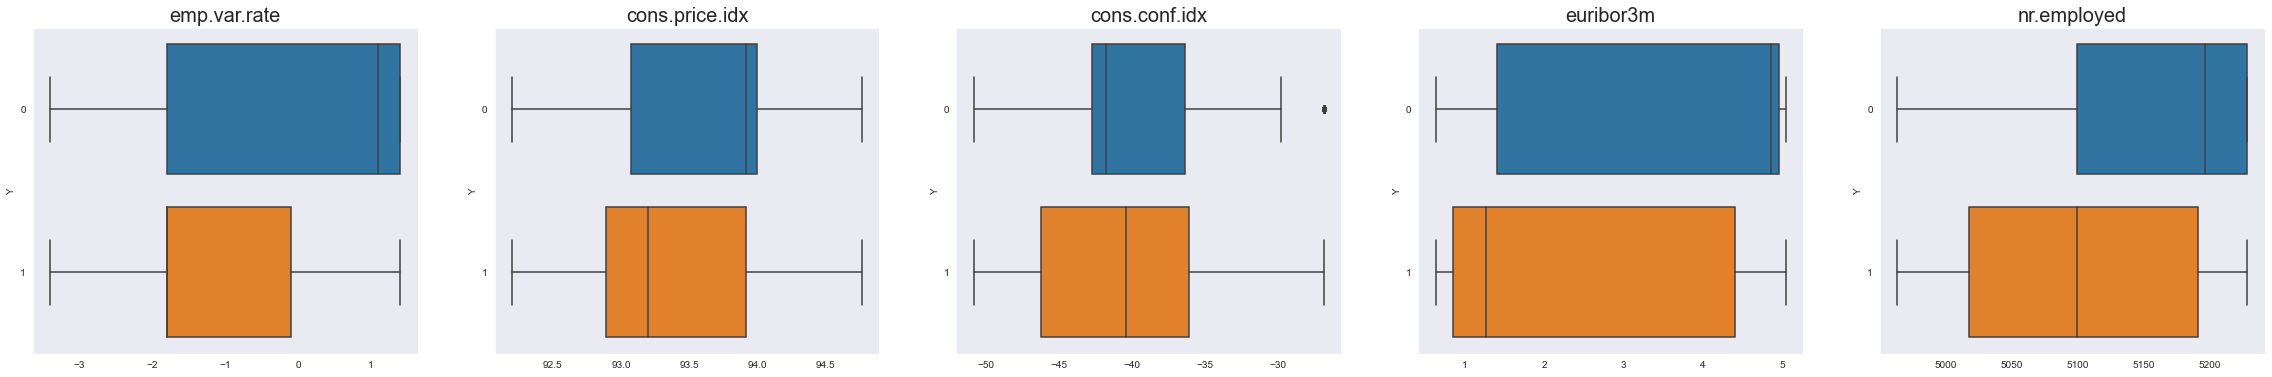

In [105]:
no_columns = 5
fig, axs = plt.subplots(1, no_columns, figsize=(40, 6))

for n, f in enumerate(social_eco_data):
    a1 = axs[n]
    exploratory_plot(f)
        
plt.subplots_adjust(wspace=.2, hspace=.3)
plt.show()

- emp.var.rate and nr.employed look like good predictors, however many of these variables may be highly correlated

### Correlation between all Socio Eco Data

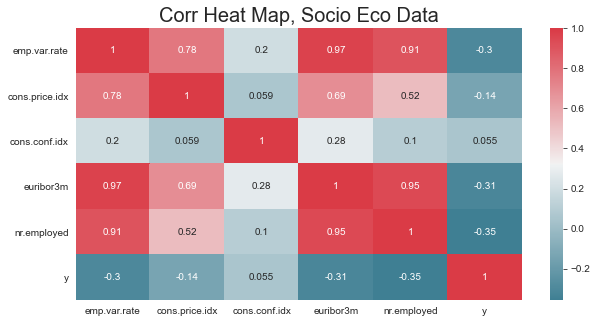

In [110]:
plt.figure(figsize=(10, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df[social_eco_data+['y']].corr(), cmap=cmap, annot = True)
plt.title('Corr Heat Map, Socio Eco Data', fontsize=20)
plt.show()

- Everything is highly correlated with the exception of cons.conf.idx
- Keep euribor3m and cons.conf.idx

In [112]:
keep += ['cons.conf.idx', 'euribor3m']

## Other Data

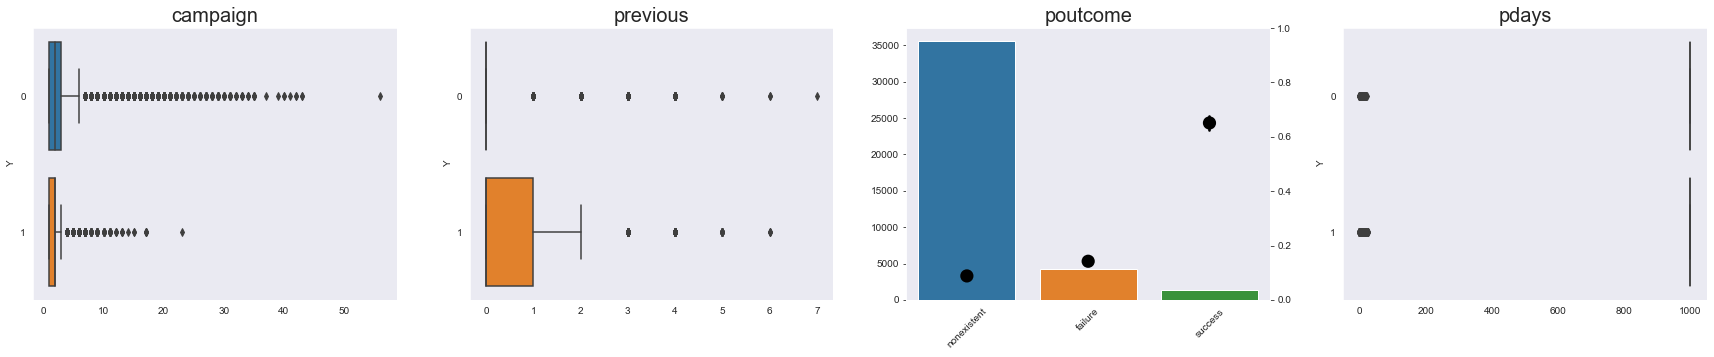

In [114]:
no_columns = 4
fig, axs = plt.subplots(1, no_columns, figsize=(30, 5))

for n, f in enumerate(other_data):
    a1 = axs[n]
    exploratory_plot(f)
        
plt.subplots_adjust(wspace=.2, hspace=.3)
plt.show()

- Most of pdays values are unknown, throw it out
- Previous Outcome is a good predictor, if they have previously converted they are likely to convert again.

## Campaign

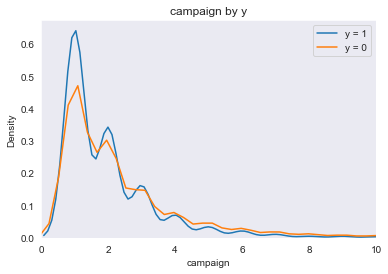

In [117]:
sns.distplot(df[df.y==1].campaign, label='y = 1', hist=False)
sns.distplot(df[df.y==0].campaign, label='y = 0', hist=False)
plt.legend()
plt.title('campaign by y')
plt.xlim(0, 10);

- Campaign could be a good predictor, number of times client has been contacted for this campaign. People usually convert within the first couple of calls.

### Previous

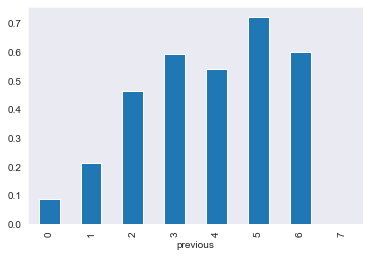

In [119]:
df.groupby('previous').y.mean().plot(kind='bar');

- Previous Calls could be a good predictor, first time call recipients are less likely to convert for this campaign.

In [121]:
keep += ['previous', 'poutcome', 'campaign']

### Mean of Y by Month / Day

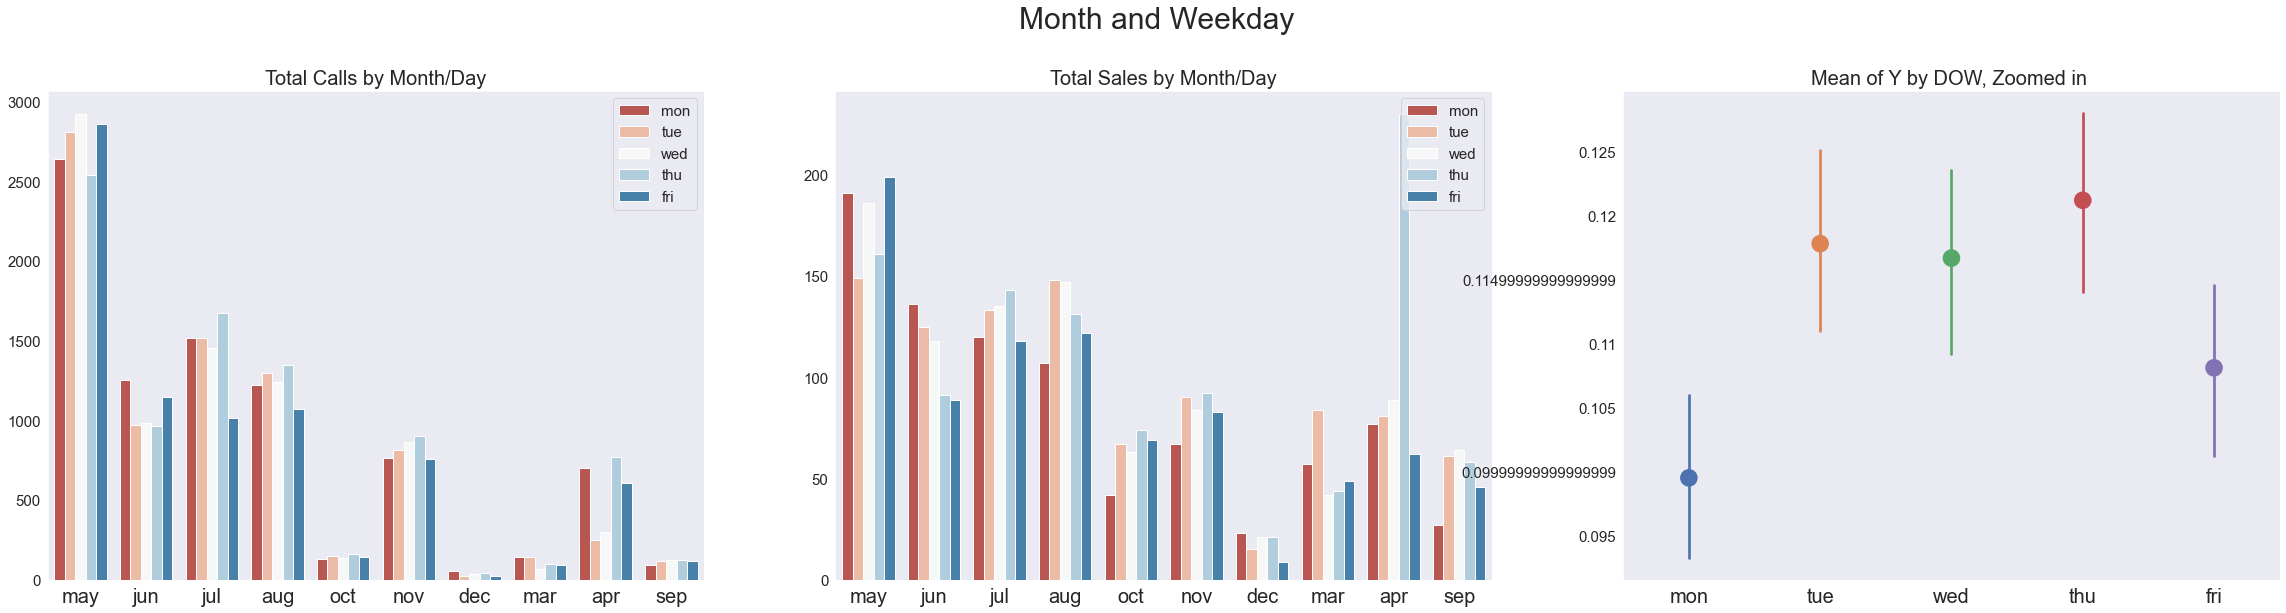

In [123]:
fig, axs = plt.subplots(1, 3, figsize=(40, 9))
fig.suptitle('Month and Weekday', fontsize=30, y=1.01, x=.51)

#first chart for whole df (calls), second for only where y=1 (sales)
dPlot = {0: [df, 'Total Calls by Month/Day'], 1: [df[df.y==1], 'Total Sales by Month/Day']}

for k, v in dPlot.items():
    a1 = axs[k]
    sns.countplot('month', hue= 'day_of_week', data=v[0], palette='RdBu', ax=a1)
    a1.set(xlabel='', ylabel='')
    a1.set_title(v[1], fontsize=20)
    a1.set_xticklabels(a1.get_xticklabels(), fontsize=20)
    a1.set_yticklabels([int(i) for i in a1.get_yticks()], fontsize=15)
    a1.legend(loc='upper right', fontsize=15, markerscale=3)

sns.pointplot('day_of_week', 'y', data=df, ci=95, linestyles='', scale=2, palette='deep', ax=axs[2])
axs[2].set(xlabel='', ylabel='')
axs[2].set_title('Mean of Y by DOW, Zoomed in ', fontsize=20)
axs[2].set_xticklabels(axs[2].get_xticklabels(), fontsize=20)
axs[2].set_yticklabels(axs[2].get_yticks(), fontsize=15)

plt.show()

- Good to include Day along with Month, as there seems to be interraction, and the p(y) is different for days in the middle of the week

In [124]:
keep += ['day_of_week']

### Histogram for all Numeric Variables

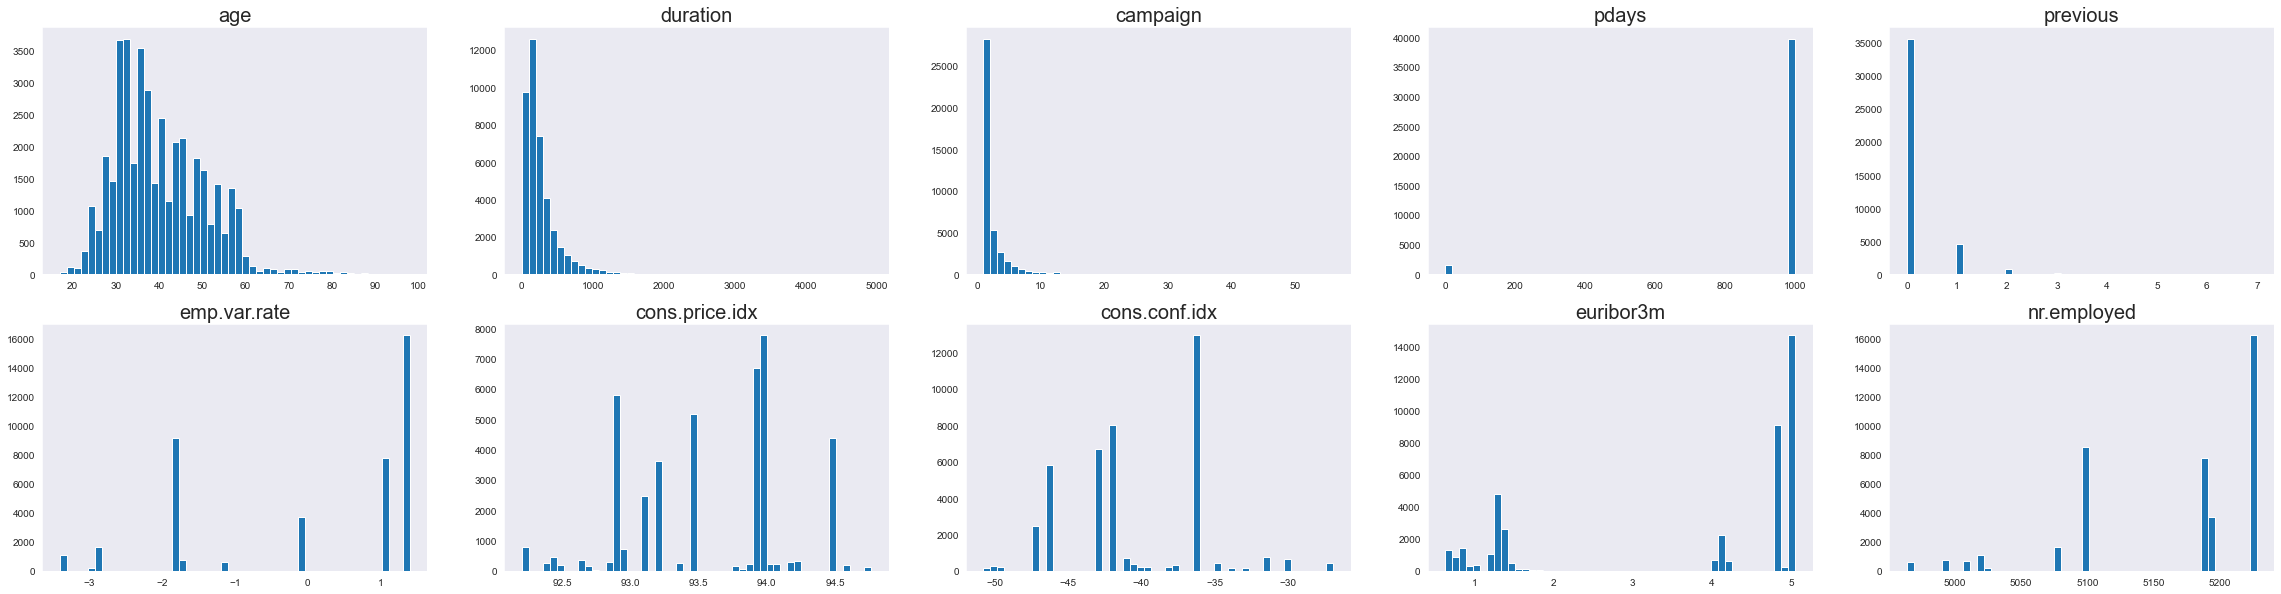

In [125]:
no_columns = 5

fig, axs = plt.subplots(2, no_columns, figsize=(40, 10))

for n, f in enumerate([k for k, v in dTypes.items() if v!='object' and k!='y']):
    if n < no_columns: 
        r,c = 0, n
    else:
        r,c = 1, n - no_columns
    a1 = axs[r,c]
    a1.hist(df[f], 50)
    a1.set_title(f, fontsize=20)
    a1.set(xlabel='', ylabel='')

plt.subplots_adjust(wspace=.2, hspace=.2)

## Mean of Y across all groups of Categorical Variables

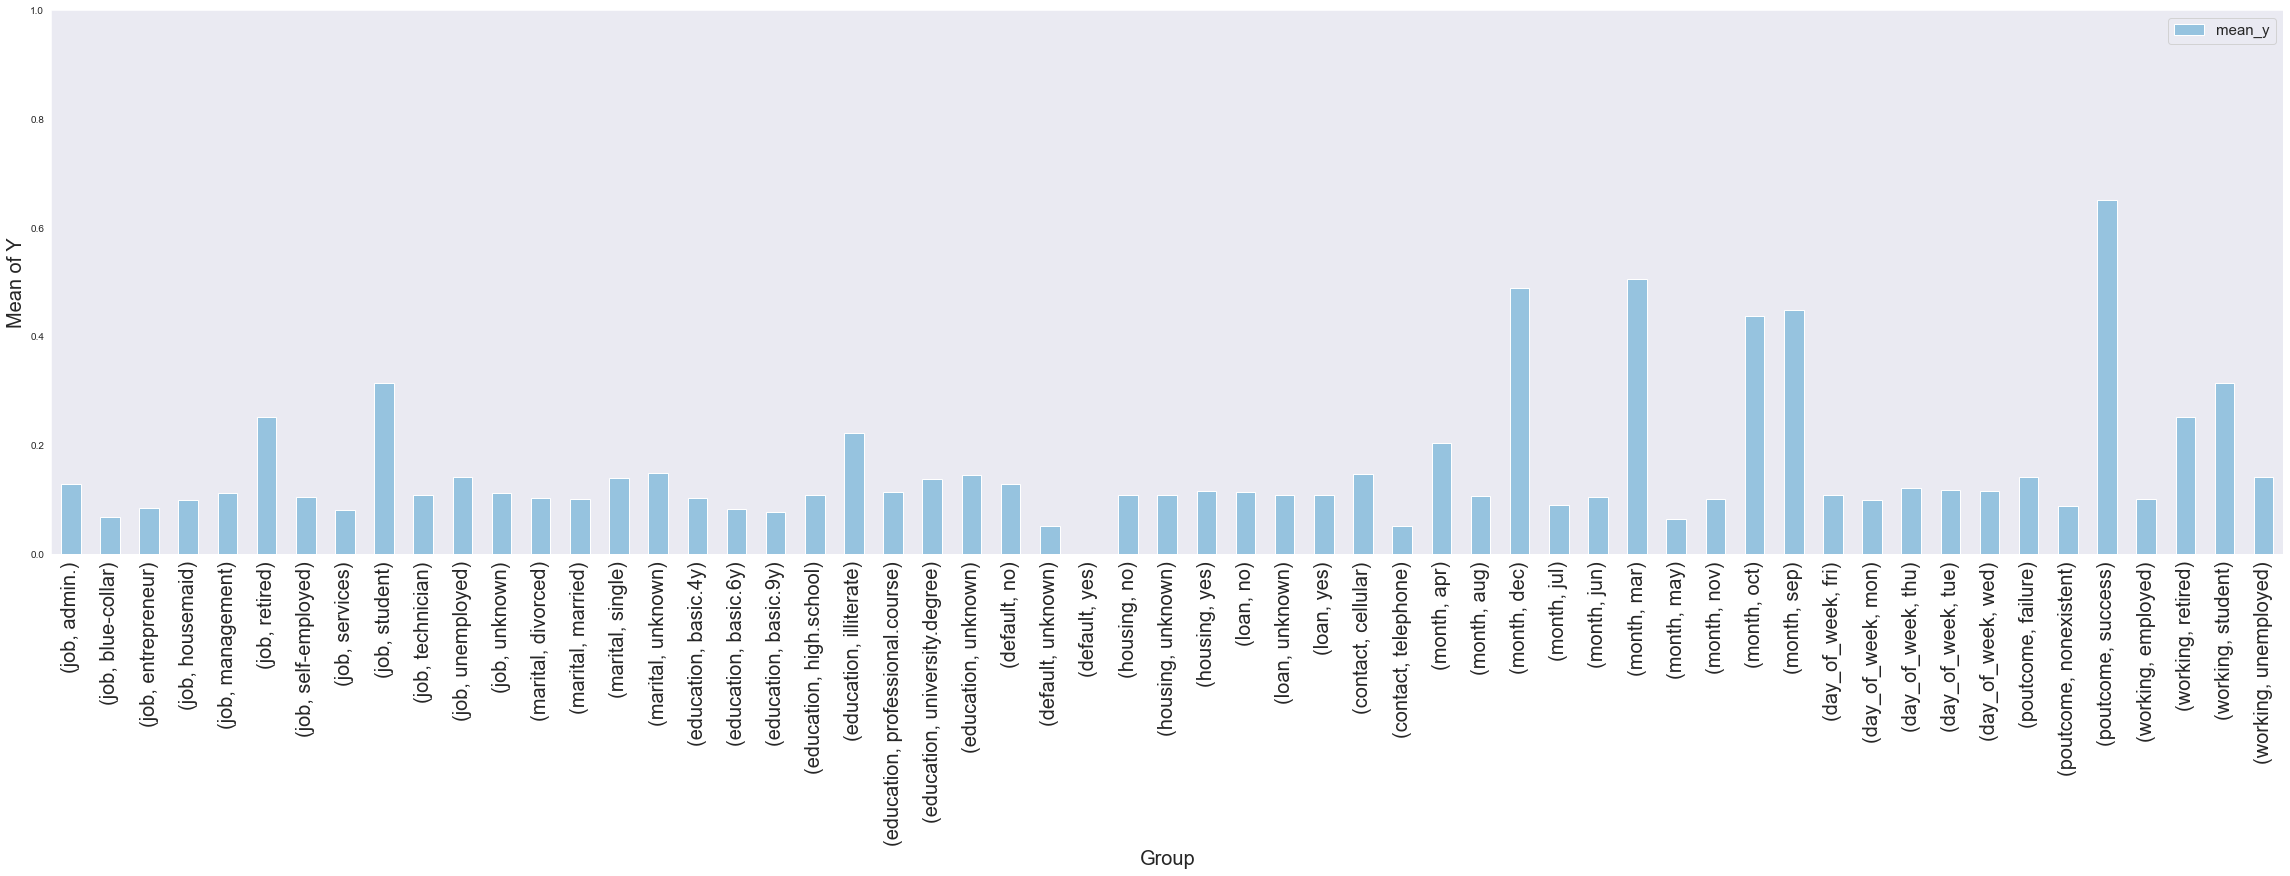

In [126]:
fig, axs = plt.subplots(1, 1, figsize=(40, 10))
sns.set_palette('Blues_d', 10)

out = []
for c in [k for k, v in dTypes.items() if v=='object']:
    for g in df.groupby(c):
        mean_y = sum(g[1].y) / float(len(g[1]))
        out.append([c, g[0], mean_y])
        
pd.DataFrame(out, columns=['variable', 'level', 'mean_y']).set_index(['variable', 'level']).plot(kind='bar', ax=axs)
axs.set_xticklabels(axs.get_xticklabels(), fontsize=20)
axs.set_ylim([0, 1])
plt.legend(loc='upper right', markerscale=3, fontsize=15)
plt.xlabel('Group', fontsize=20)
plt.ylabel('Mean of Y', fontsize=20)
plt.show()

### Corr map for Numeric Variables to Keep

In [128]:
keep

['working',
 'age',
 'contact',
 'month',
 'cons.conf.idx',
 'euribor3m',
 'previous',
 'poutcome',
 'campaign',
 'day_of_week']

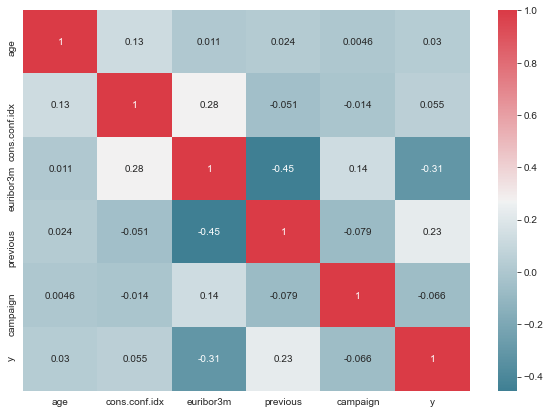

In [129]:
plt.figure(figsize=(10, 7))
sns.heatmap(df[[i for i in keep if str(df[i].dtype)!='object']+['y']].corr(), cmap=cmap, annot = True);

### Make changes to existing predictors based on Exploratory Analysis

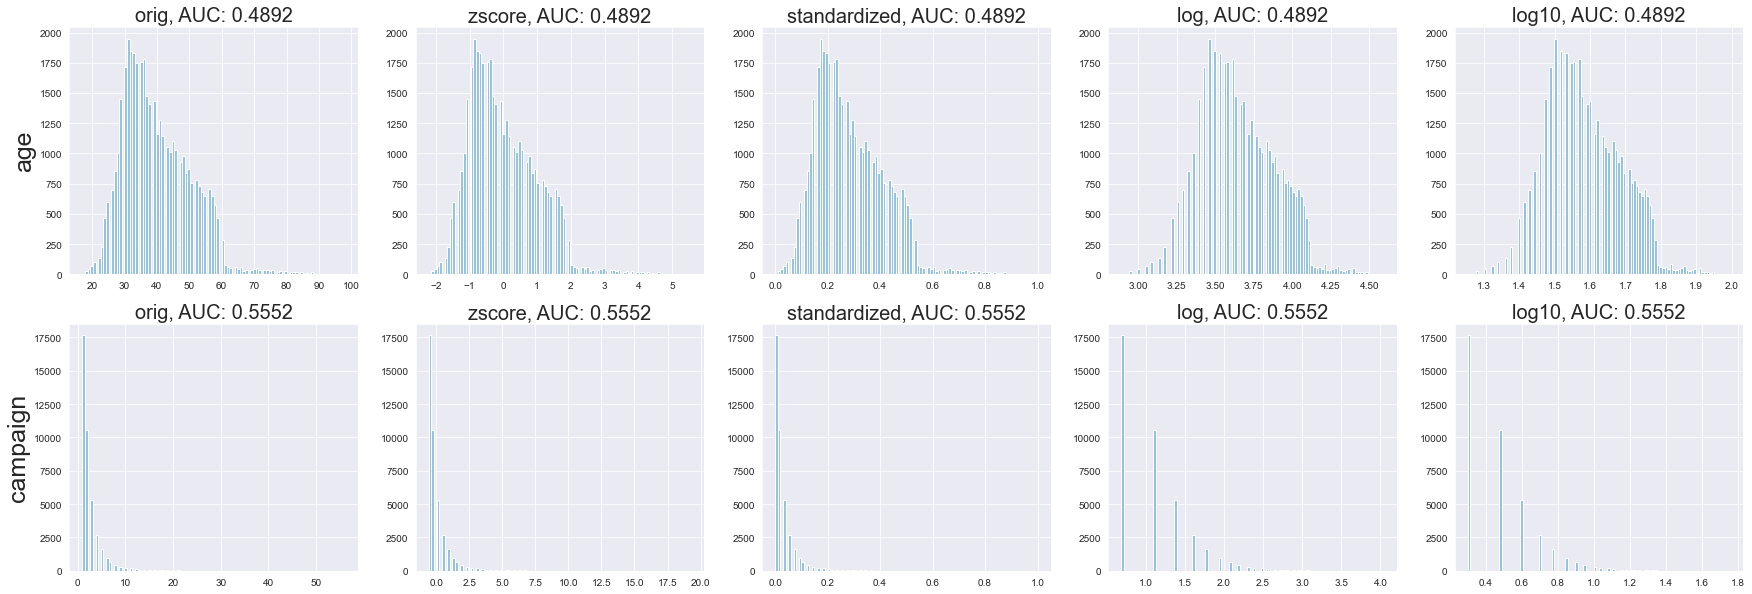

In [130]:
sns.set_style('darkgrid')
_, axs = plt.subplots(2, 5, figsize=(30, 10))


def plot_transformation(col, row):
    mu, stdev = df[col].mean(), df[col].std()
    mn, mx = df[col].min(), df[col].max()
    plots = {'orig': df[col].copy(),
            'zscore': [(x - mu) / float(stdev) for x in df[col]],
            'standardized': [(x - mn) / float(mx - mn) for x in df[col]],
            'log': [np.log(x+1) for x in df[col]],
            'log10': [np.log10(x+1) for x in df[col]]
            }
    for n, tr in enumerate(plots):
        axs[row, n].hist(
            plots[tr], bins=100)
        X, y = pd.DataFrame(plots[tr]), df.y
        m = lm.LogisticRegression()
        m.fit(X, y)
        #axs[row, col].set_title(tr + ', Accuracy: ' + str(round(m.score(X, y), 2)), fontsize=20)
        axs[row, n].set_title(tr + ', AUC: ' + str(round(roc_auc_score(y, m.predict_proba(X)[:, -1,]), 4)), fontsize=20)
        axs[row, 0].set_ylabel(col, fontsize=25)

plot_transformation('age', 0)
plot_transformation('campaign', 1)
plt.show()

### Modeling

#### Single Predictor Model Scoring

In [132]:
pd.DataFrame.from_dict({col: single_predictor_auc(col) for col in df.columns}, orient='index').sort_values(0, ascending=False).rename(columns={0: 'AUC', 1: 'Avg PR'})

,AUC,Avg PR
y,1.000000,1.000000
duration,0.818446,0.394074
nr.employed,0.748997,0.324444
euribor3m,0.743478,0.341190
emp.var.rate,0.716753,0.242727
month,0.658107,0.236716
poutcome,0.613842,0.236462
cons.price.idx,0.610562,0.197023
job,0.610272,0.165816
contact,0.610239,0.141487


- As single predictors, Socio Eco metrics give us the best AUC. Duration, as expected, performs excellently.

### Only Columns we are keeping (Keep Model)

['working', 'age', 'contact', 'month', 'cons.conf.idx', 'euribor3m', 'previous', 'poutcome', 'campaign', 'day_of_week']
                 feature      coef      odds
19      poutcome_success  1.860714  6.428325
13             month_mar  0.803247  2.232779
14             month_may -0.780990  0.457953
18  poutcome_nonexistent  0.619679  1.858332
2              euribor3m -0.482425  0.617285
11             month_jul  0.359613  1.432775
6        working_student  0.348981  1.417622
5        working_retired  0.325749  1.385068
16             month_oct  0.287844  1.333549
8      contact_telephone -0.257193  0.773219
12             month_jun  0.208280  1.231558
3               previous  0.197911  1.218854
15             month_nov -0.165567  0.847413
23       day_of_week_wed  0.160034  1.173551
10             month_dec  0.155144  1.167827
20       day_of_week_mon -0.148697  0.861830
17             month_sep  0.123124  1.131024
21       day_of_week_thu  0.112899  1.119519
9              month_aug 

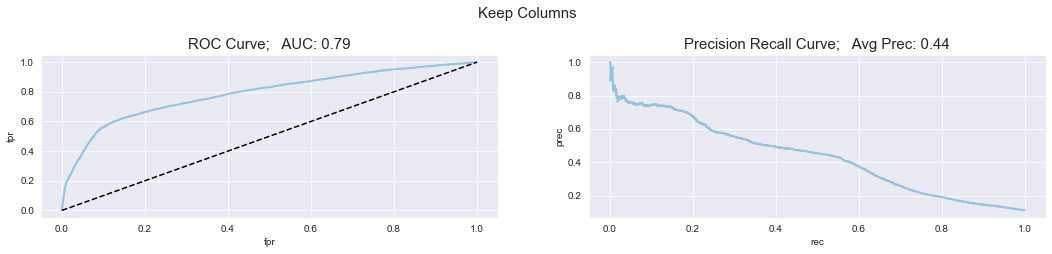

In [133]:
run_LR(df, keep, 'Keep Columns')

- This model comes close to the AUC of duration (benchmark), and has a better PR score.
- Using a single Socio Eco predictor will give you comparable AUC, but not as good PR score.
- If you have previously converted, you are more than 6 times more likely to convert on this call.


### Compare to using All Data

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'working']
                          feature      coef      odds
5                  cons.price.idx  0.229784  1.258328
7                       euribor3m -0.177415  0.837432
4                    emp.var.rate -0.151180  0.859693
42                      month_may -0.122101  0.885059
36              contact_telephone -0.065756  0.936359
30                default_unknown -0.042846  0.958059
9                 job_blue-collar -0.042367  0.958518
39                      month_jul  0.037374  1.038081
28    education_university.degree  0.037332  1.038038
21                 marital_single  0.034391  1.034989
50           poutcome_nonexistent  0.031830  1.032342
41                      month_mar  0.030607  1.031080
20                marital_married -0.027457  0.972917
46   

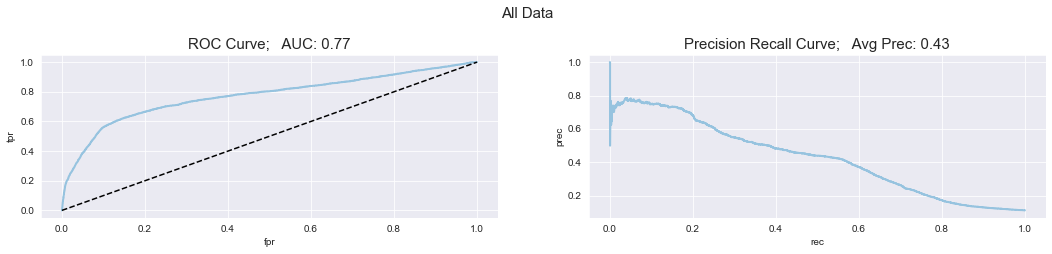

In [135]:
run_LR(df, [p for p in df.columns if p!='duration' and p!='y'], 'All Data')

- Keep Model is just as good

### Compare to using all Eco Data

['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
          feature      coef      odds
1  cons.price.idx  0.397161  1.487596
3       euribor3m -0.212565  0.808508
0    emp.var.rate -0.147966  0.862460
2   cons.conf.idx  0.043948  1.044928
4     nr.employed -0.007168  0.992857


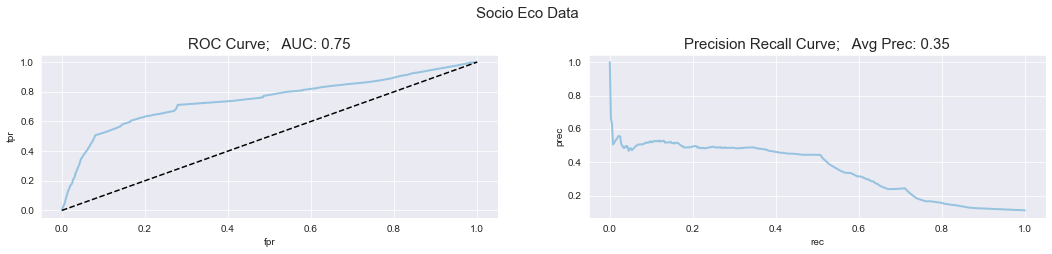

In [137]:
run_LR(df, social_eco_data, 'Socio Eco Data')

## Run LR and KNN with Keep predictors, Cross Validate

In [148]:
from sklearn.model_selection import GridSearchCV

In [142]:
#keep only importand predictors, run LR / KNN
df_model = df[keep + ['y']]

df_model = get_dummies(df_model, [i for i in df_model.columns if df[i].dtype=='object'])

X, y = df_model[[c for c in df_model.columns if c!='y']], df_model.y

In [147]:
params = {'C': float(1)/np.arange(1, 5000, 100),
          'fit_intercept': [True, False]}

gs = GridSearchCV(lm.LogisticRegression(penalty='l2'), 
                  param_grid=params,
                  cv=5, 
                  scoring='roc_auc')
gs.fit(X,y)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e+00, 9.90099010e-03, 4.97512438e-03, 3.32225914e-03,
       2.49376559e-03, 1.99600798e-03, 1.66389351e-03, 1.42653352e-03,
       1.24843945e-03, 1.10987791e-03, 9.99000999e-04, 9.08265213e-04,
       8.32639467e-04, 7.68639508e-04, 7.13775874e-04, 6.66222518e-04,
       6.24609619e-04, 5.87889477e-04, 5.552470...
       3.57015352e-04, 3.44708721e-04, 3.33222259e-04, 3.22476620e-04,
       3.12402374e-04, 3.02938503e-04, 2.94031167e-04, 2.85632676e-04,
       2.77700639e-04, 2.70197244e-04, 2.63088661e-04, 2.56344527e-04,
       2.49937516e-04, 2.43842965e-04, 2.38038562e-04, 2.32504069e-04,
       2.27221086e-04, 2.22172850e-04, 2.17344056e-04, 2.12720698e-04,
       2.08289940e-04, 2.04039992e-04]),
                         'fit_intercept': [True, False]},
             scoring='roc_auc')

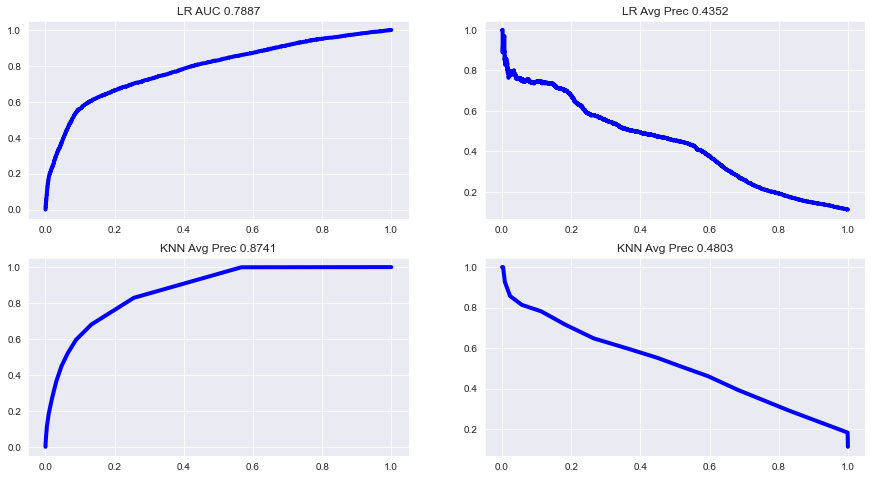

In [163]:
lr_model = lm.LogisticRegression(C=1, penalty='l2', fit_intercept=True)
knn_model = neighbors.KNeighborsClassifier(n_neighbors=15, weights='uniform') #auc gain diminishes around 15

df_model = df[keep + ['y']]

df_model = get_dummies(df_model, [i for i in df_model.columns if df[i].dtype=='object'])

X, y = df_model[[c for c in df_model.columns if c!='y']], df_model.y

lr_model.fit(X, y)
knn_model.fit(X, y)

_, axs = plt.subplots(2, 2, figsize=(15, 8))
sns.set_style('darkgrid')

fpr, tpr, _ = roc_curve(y, lr_model.predict_proba(X)[:, -1])
axs[0,0].plot(fpr, tpr, color='blue', linewidth=4)
auc = roc_auc_score(y, lr_model.predict_proba(X)[:, -1])
axs[0,0].set_title('LR AUC %s'%round(auc, 4))
fpr, tpr, _ = roc_curve(y, knn_model.predict_proba(X)[:, -1])
axs[1,0].plot(fpr, tpr, color='blue', linewidth=4)
auc = roc_auc_score(y, knn_model.predict_proba(X)[:, -1])
axs[1,0].set_title('KNN Avg Prec %s'%round(auc, 4))

prec, rec, _ = precision_recall_curve(y, lr_model.predict_proba(X)[:, -1])
avg_prec = str(round(average_precision_score(y, lr_model.predict_proba(X)[:, -1]), 4))
axs[0,1].plot(rec, prec, color='blue', linewidth=4)
axs[0,1].set_title('LR Avg Prec %s'%avg_prec)
prec, rec, _ = precision_recall_curve(y, knn_model.predict_proba(X)[:, -1])
avg_prec = str(round(average_precision_score(y, knn_model.predict_proba(X)[:, -1]), 4))
axs[1,1].plot(rec, prec, color='blue', linewidth=4)
axs[1,1].set_title('KNN Avg Prec %s'%avg_prec)

plt.show()

In [164]:
odds = [np.exp(i) for i in lr_model.coef_[0]]
absv = [abs(i) for i in lr_model.coef_[0]]
pd.DataFrame(zip(X.columns.tolist(), list(lr_model.coef_[0]), odds, absv), columns=['feature', 'coef', 'odds', 'absv']).sort_values('absv', ascending=False).drop('absv', axis=1)

,feature,coef,odds
19,poutcome_success,1.860714,6.428325
13,month_mar,0.803247,2.232779
14,month_may,-0.780990,0.457953
18,poutcome_nonexistent,0.619679,1.858332
2,euribor3m,-0.482425,0.617285
11,month_jul,0.359613,1.432775
6,working_student,0.348981,1.417622
5,working_retired,0.325749,1.385068
16,month_oct,0.287844,1.333549
8,contact_telephone,-0.257193,0.773219


- If the previous marketing campaign was a success for this customer, the odds this customer will convert are over 6x higher than if the outcome of the previous campaign was a failure. About 3x higher than if it were unknown.
- If the previous marketing campaign was a failure, you are half as likely to convert than if it was unknown (poutcome)
- Calls in March convert great, calls in May convert terribly (month)
- Retired and Student convert better than Unemployed or Working (working)
- Contact on a House Phone is 25% less likely to conver than a Cell Phone (contact)
- Wednesday is the best day to call the customer, Mon and Fri the worst (day_of_week)
- The more calls made to this client before this campaign, the more likely they are to convert (previous)
- The more calls made to this client during this campaign, the less likely they are to convert (campaign)

### Use KNN to predict duration from Keep features

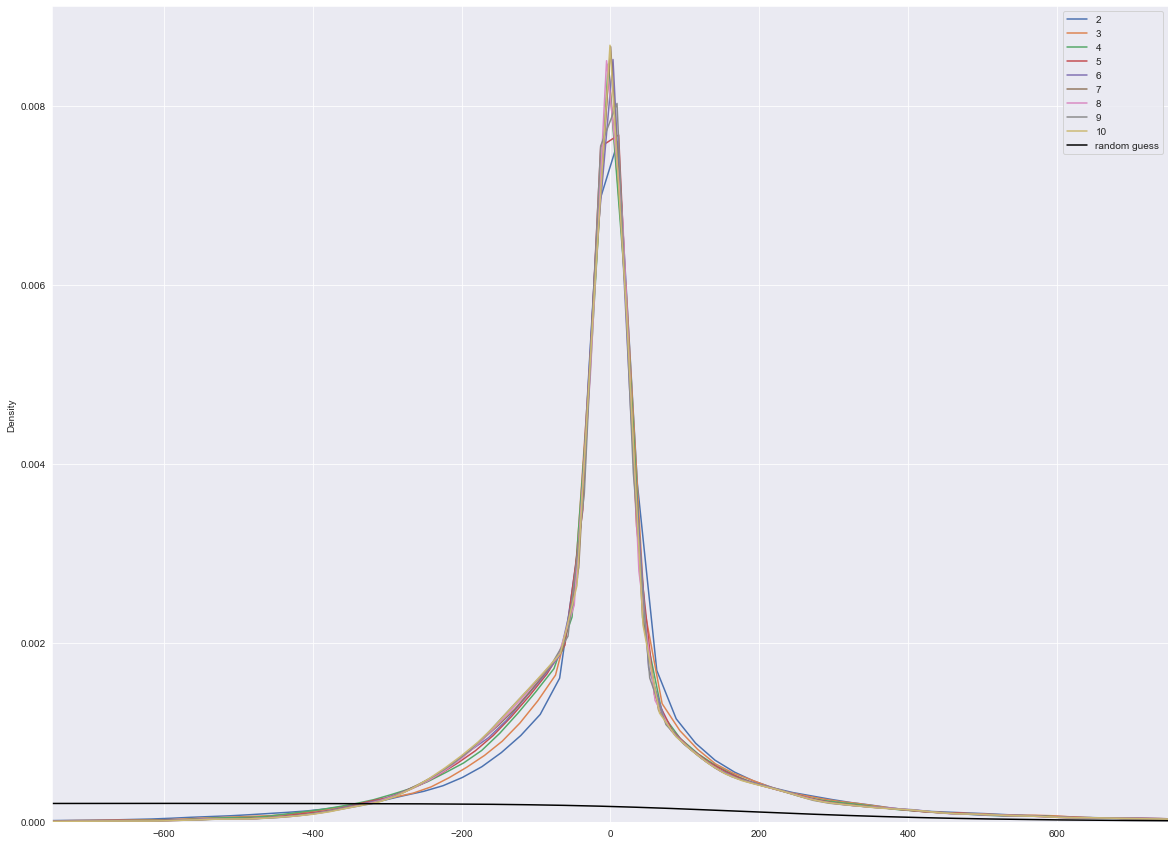

In [169]:
sns.set_palette('deep')
plt.figure(figsize=(20, 15))
X, y = X.copy(), df.duration
for n in range(2, 11):
    knnr = neighbors.KNeighborsRegressor(n_neighbors=n, weights='distance')
    errors = np.array(y) - np.array(knnr.fit(X, y).predict(X))
    sns.distplot(errors, hist=False, label=n)

errors = np.array(y) - np.random.randint(min(y), max(y), len(y))
sns.distplot(errors, hist=False, label='random guess', color='black')
plt.xlim(-750, 750)
plt.legend(loc='best')
plt.show()

- Since duration and y are closely correlated, it might be better to use KNN to predict duration